# Importing libraries

In [33]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import warnings

# Ignore DeprecationWarning and FutureWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


# Getting the data

In [8]:
# Load the CSV files
papers_df = pd.read_csv('papers.csv')
institutions_df = pd.read_csv('institutions.csv')
authors_df = pd.read_csv('authors.csv')

# Data Cleaning

In [9]:
# Delete unwanted columns
papers_df.drop(['Unnamed: 0', 'full_text' , "paper_index"], axis=1, inplace=True)
institutions_df.drop(['Unnamed: 0'], axis=1, inplace=True)
authors_df.drop(['is_chinese', "paper_index", "name"], axis=1, inplace=True)

In [10]:
# Custom function to merge institution information
def merge_institution_info(row):
    institution_name = row['institution']
    if institution_name in institutions_df['institutions'].values:
        matching_row = institutions_df[institutions_df['institutions'] == institution_name]
        row['city'] = matching_row['city'].values[0]
        row['state'] = matching_row['state'].values[0]
        row['country'] = matching_row['country'].values[0]
    else:
        row['institution'] = 'other'
        row['city'] = 'N/A'
        row['state'] = 'N/A'
        row['country'] = 'N/A'
    return row

authors_df = authors_df.apply(merge_institution_info, axis=1)
authors_df.head()

,institution,name_in_database,city,state,country
0,other,Seongmin Ok,N/A,N/A,N/A
1,google,Sangnie Bhardwaj,Mountain View,CA,US
2,google,Ian Fischer,Mountain View,CA,US
3,google,Johannes BallÃ©,Mountain View,CA,US
4,google,Troy Chinen,Mountain View,CA,US


In [18]:
#Cleaning the title and abstract

# Replace null values in 'abstract' column with empty strings
papers_df['abstract'].fillna("", inplace=True)

# Remove punctuation and Convert the titles to lowercase
papers_df['title_processed'] = papers_df['title'].map(lambda x: re.sub('[,\.!?]', '', x)).map(lambda x: x.lower())
papers_df['abstract_processed'] = papers_df['abstract'].map(lambda x: re.sub('[,\.!?]', '', x)).map(lambda x: x.lower())
papers_df

,title,abstract,year,title_processed,abstract_processed
0,A graph similarity for deep learning,Graph neural networks (GNNs) have been success...,2020,a graph similarity for deep learning,graph neural networks (gnns) have been success...
1,An Unsupervised Information-Theoretic Perceptu...,Tractable models of human perception have prov...,2020,an unsupervised information-theoretic perceptu...,tractable models of human perception have prov...
2,Self-Supervised MultiModal Versatile Networks,Videos are a rich source of multi-modal superv...,2020,self-supervised multimodal versatile networks,videos are a rich source of multi-modal superv...
3,"Benchmarking Deep Inverse Models over time, an...",We consider the task of solving generic invers...,2020,benchmarking deep inverse models over time and...,we consider the task of solving generic invers...
4,Off-Policy Evaluation and Learning for Externa...,We consider the evaluation and training of a n...,2020,off-policy evaluation and learning for externa...,we consider the evaluation and training of a n...
...,...,...,...,...,...
11275,Discrete Object Generation with Reversible Ind...,The success of generative modeling in continuo...,2019,discrete object generation with reversible ind...,the success of generative modeling in continuo...
11276,Adaptively Aligned Image Captioning via Adapti...,Recent neural models for image captioning usua...,2019,adaptively aligned image captioning via adapti...,recent neural models for image captioning usua...
11277,Fully Dynamic Consistent Facility Location,We consider classic clustering problems in ful...,2019,fully dynamic consistent facility location,we consider classic clustering problems in ful...
11278,Efficient Rematerialization for Deep Networks,"When training complex neural networks, memory ...",2019,efficient rematerialization for deep networks,when training complex neural networks memory u...


## Data Visualization:

**Explanation:**
In this step, we will create visualizations to showcase some general information about the dataset. We'll visualize the distribution of articles over the years and potentially explore other patterns.

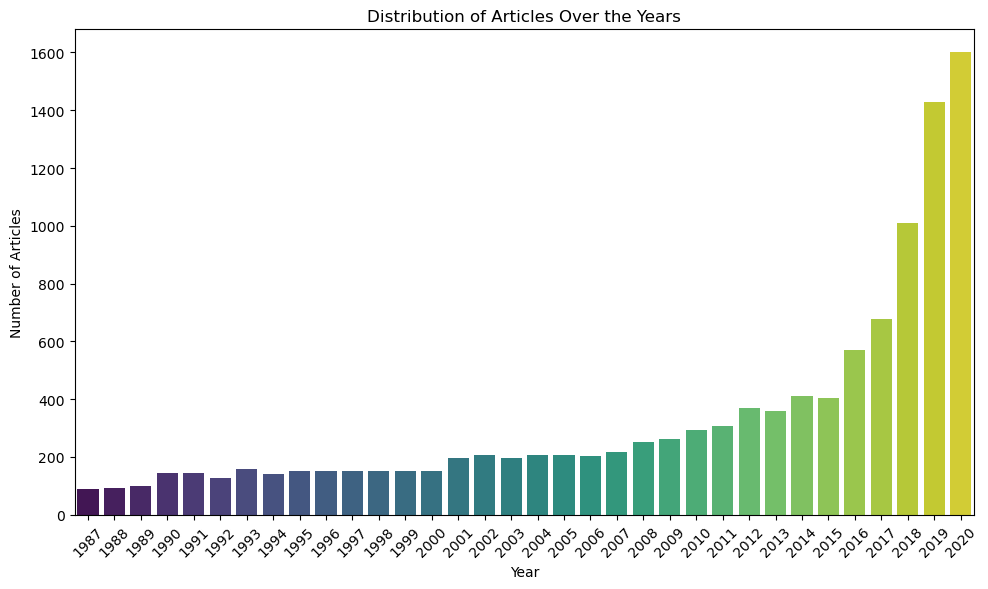

In [21]:
# Distribution of articles over the years
plt.figure(figsize=(10, 6))
sns.countplot(data=papers_df, x='year', palette='viridis')
plt.title('Distribution of Articles Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


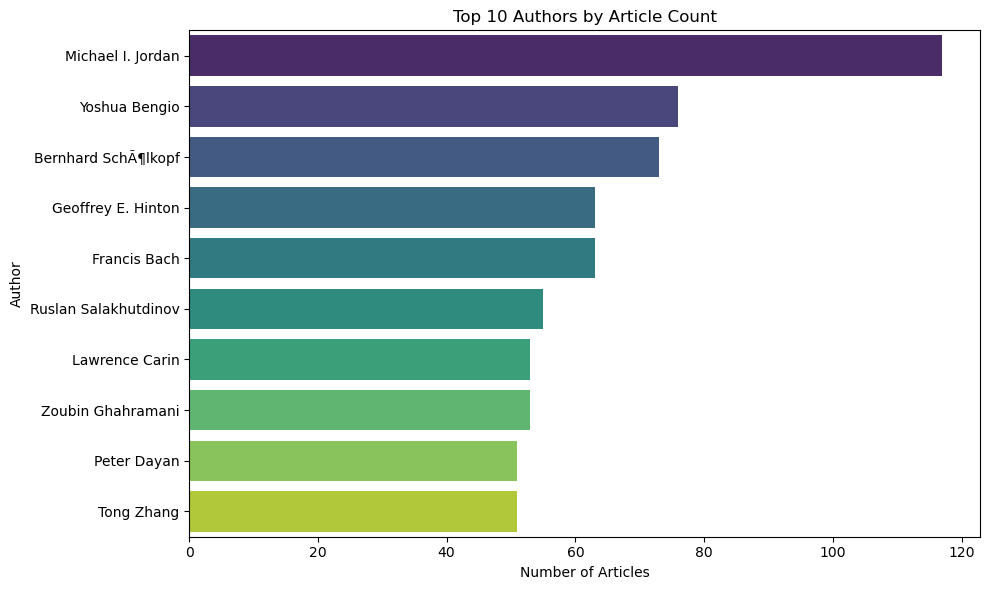

In [22]:
# Additional exploratory graphs
# For example, the distribution of articles by authors or institutions

# Distribution of articles by authors (top 10 authors)
plt.figure(figsize=(10, 6))
top_authors = authors_df['name_in_database'].value_counts().nlargest(10)
sns.barplot(x=top_authors.values, y=top_authors.index, palette='viridis')
plt.title('Top 10 Authors by Article Count')
plt.xlabel('Number of Articles')
plt.ylabel('Author')
plt.tight_layout()
plt.show()


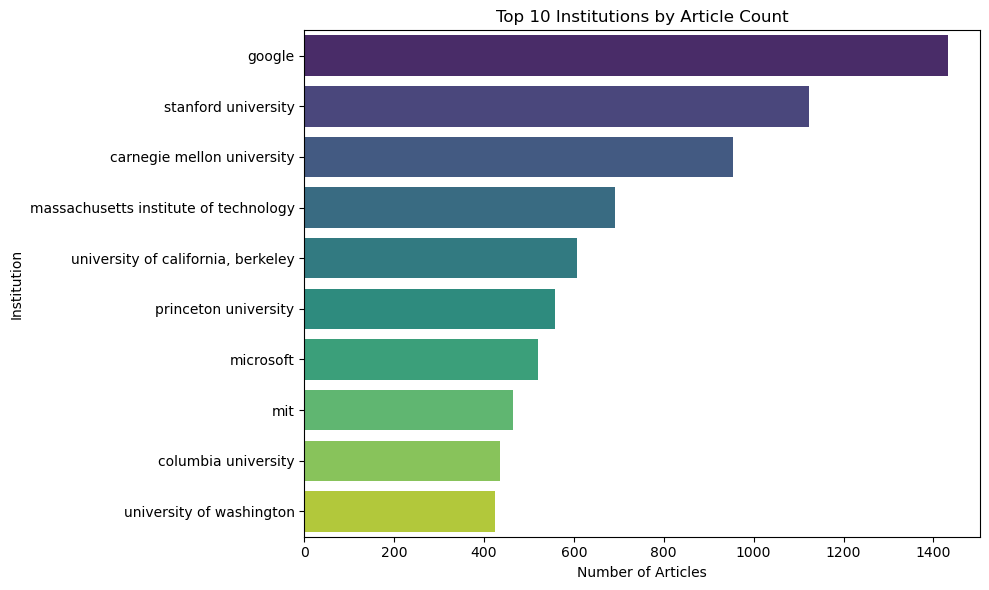

In [25]:
# Distribution of articles by institutions (top 10 institutions)
plt.figure(figsize=(10, 6))
top_institutions = authors_df[authors_df['institution'] != 'other']['institution'].value_counts().nlargest(10)
sns.barplot(x=top_institutions.values, y=top_institutions.index, palette='viridis')
plt.title('Top 10 Institutions by Article Count')
plt.xlabel('Number of Articles')
plt.ylabel('Institution')
plt.tight_layout()
plt.show()

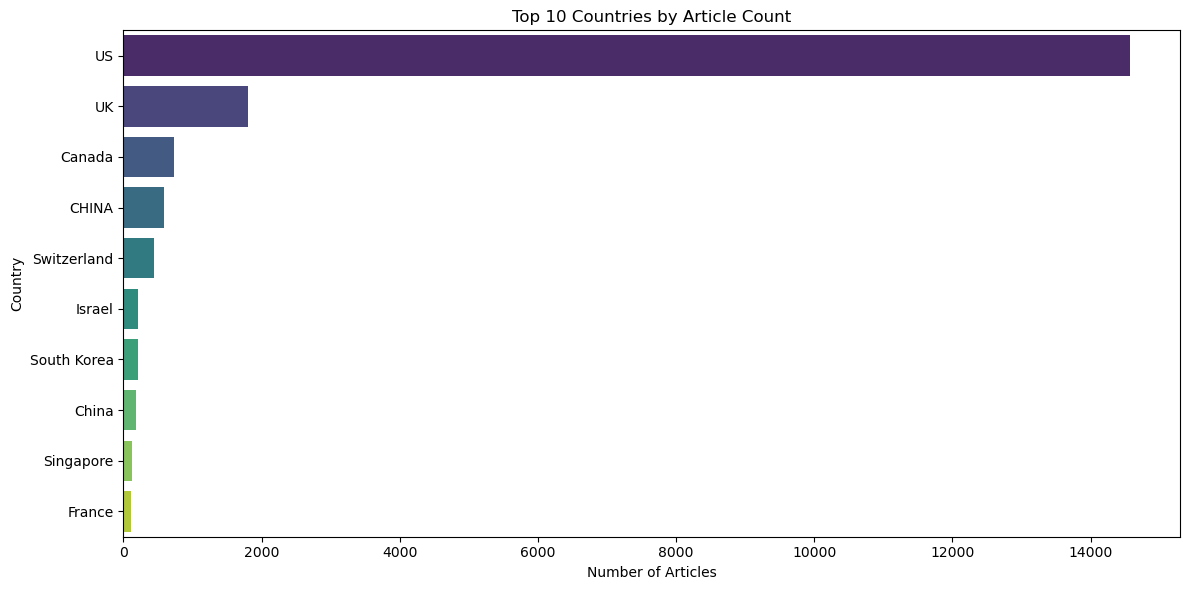

In [27]:
# Distribution of articles by countries (top 10 countries)
plt.figure(figsize=(12, 6))
top_countries = authors_df[authors_df['country'] != 'N/A']['country'].value_counts().nlargest(10)
sns.barplot(x=top_countries.values, y=top_countries.index, palette='viridis')
plt.title('Top 10 Countries by Article Count')
plt.xlabel('Number of Articles')
plt.ylabel('Country')
plt.tight_layout()
plt.show()


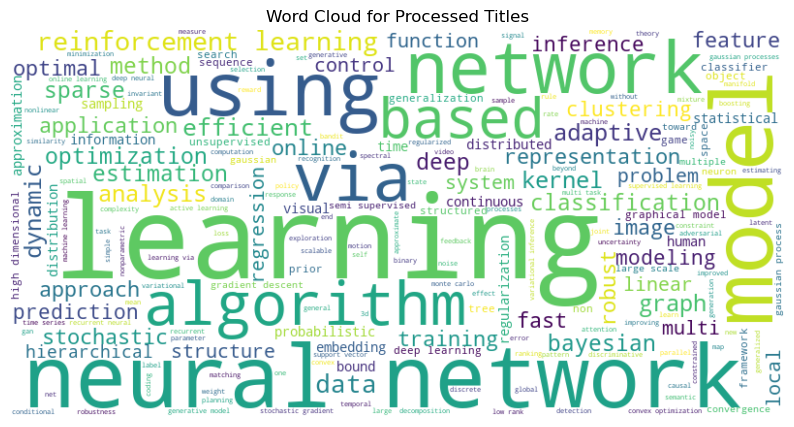

In [30]:
# Generate word cloud for processed titles
title_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(' '.join(papers_df['title_processed']))

# Display the word cloud for titles
plt.figure(figsize=(10, 6))
plt.imshow(title_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Processed Titles')
plt.axis('off')
plt.show()


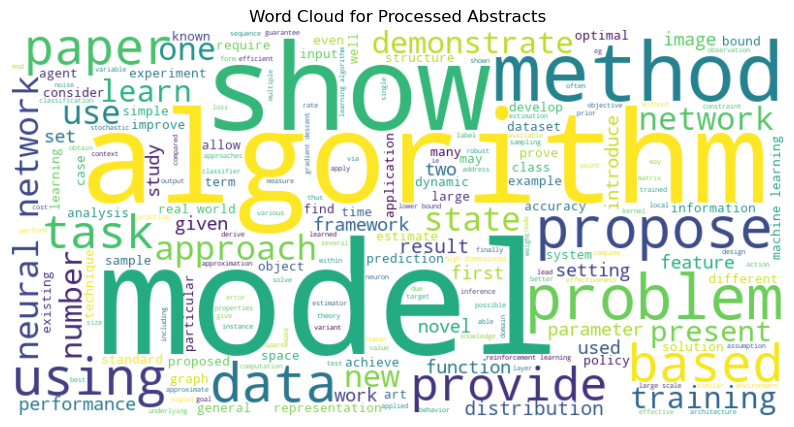

In [32]:
# Generate word cloud for processed abstracts
abstract_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(' '.join(papers_df['abstract_processed']))

# Display the word cloud for abstracts
plt.figure(figsize=(10, 6))
plt.imshow(abstract_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Processed Abstracts')
plt.axis('off')
plt.show()


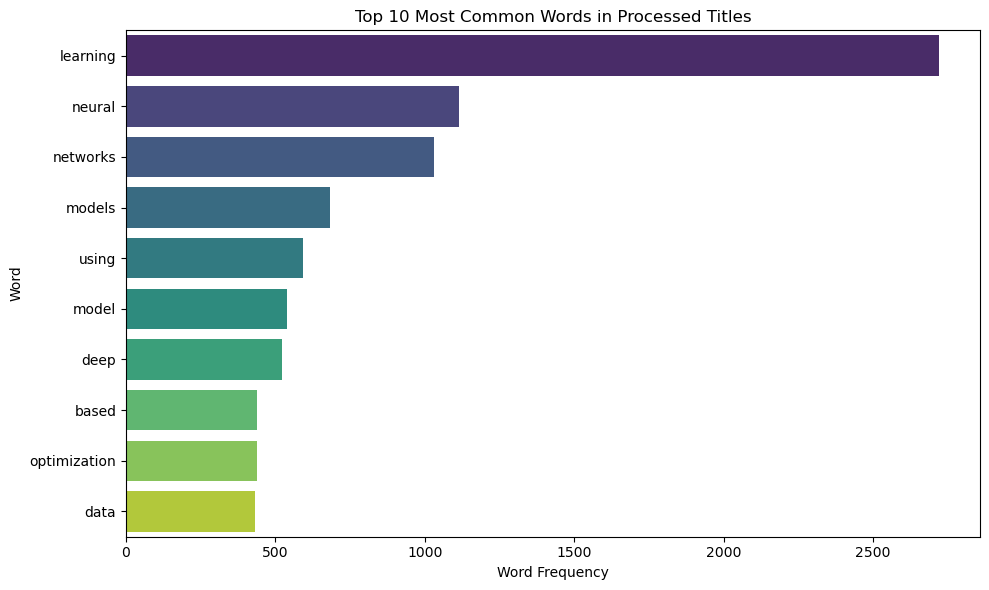

In [35]:
processed_titles = papers_df['title_processed'].tolist()

# Initialize CountVectorizer
vectorizer_title = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Fit the vectorizer on the processed titles
X_title = vectorizer_title.fit_transform(processed_titles)

# Get the feature names (words) from the CountVectorizer
feature_names = vectorizer_title.get_feature_names_out()

# Get the word frequencies from the document-term matrix
word_frequencies = np.sum(X_title.toarray(), axis=0)

# Create a dictionary of words and their corresponding frequencies
word_freq_dict = dict(zip(feature_names, word_frequencies))

# Get the top 10 most common words
top_common_words = sorted(word_freq_dict.items(), key=lambda x: x[1], reverse=True)[:10]
top_common_words_words = [word[0] for word in top_common_words]
top_common_words_freqs = [word[1] for word in top_common_words]

# Create a bar plot for the 10 most common words
plt.figure(figsize=(10, 6))
sns.barplot(x=top_common_words_freqs, y=top_common_words_words, palette='viridis')
plt.title('Top 10 Most Common Words in Processed Titles')
plt.xlabel('Word Frequency')
plt.ylabel('Word')
plt.tight_layout()
plt.show()


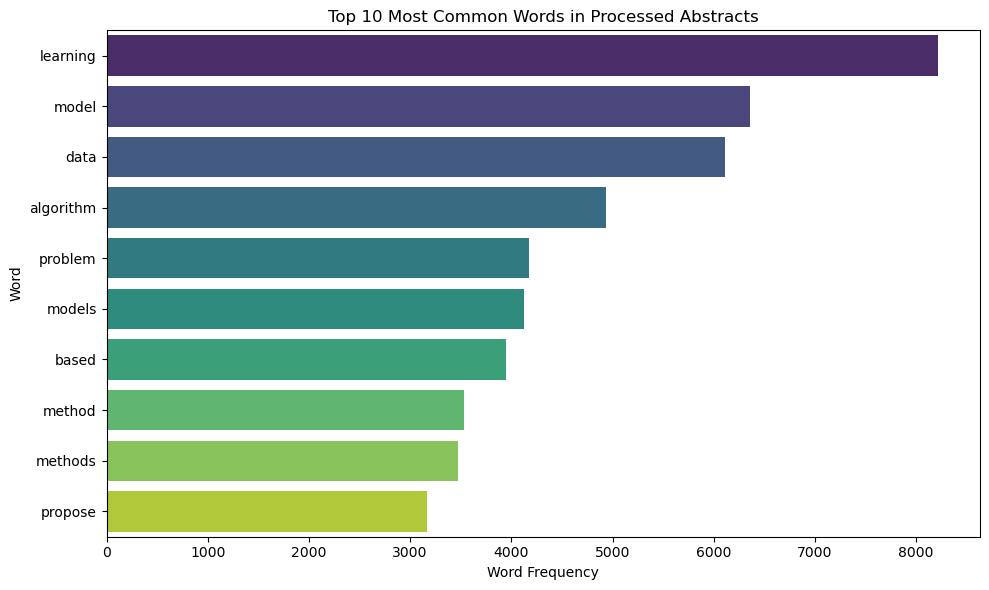

In [36]:
processed_abstracts = papers_df['abstract_processed'].tolist()

# Initialize CountVectorizer
vectorizer_abstract = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Fit the vectorizer on the processed abstracts
X_abstract = vectorizer_abstract.fit_transform(processed_abstracts)

# Get the feature names (words) from the CountVectorizer
feature_names_abstract = vectorizer_abstract.get_feature_names_out()

# Get the word frequencies from the document-term matrix
word_frequencies_abstract = np.sum(X_abstract.toarray(), axis=0)

# Create a dictionary of words and their corresponding frequencies
word_freq_dict_abstract = dict(zip(feature_names_abstract, word_frequencies_abstract))

# Get the top 10 most common words
top_common_words_abstract = sorted(word_freq_dict_abstract.items(), key=lambda x: x[1], reverse=True)[:10]
top_common_words_words_abstract = [word[0] for word in top_common_words_abstract]
top_common_words_freqs_abstract = [word[1] for word in top_common_words_abstract]

# Create a bar plot for the 10 most common words in abstracts
plt.figure(figsize=(10, 6))
sns.barplot(x=top_common_words_freqs_abstract, y=top_common_words_words_abstract, palette='viridis')
plt.title('Top 10 Most Common Words in Processed Abstracts')
plt.xlabel('Word Frequency')
plt.ylabel('Word')
plt.tight_layout()
plt.show()


### LDA Analysis

In this step, we will apply Latent Dirichlet Allocation (LDA) to the processed titles and processed abstracts of the papers. LDA is a topic modeling technique that can identify hidden topics within a collection of documents. By running LDA on the processed titles, we aim to uncover the main topics represented in the titles of the papers.


In [41]:
# Since we already did int the data visualization phase.

# Apply LDA
num_topics = 10
lda_model = LDA(n_components=num_topics, random_state=42)

# Fit the LDA model to the data
lda_model.fit(X_title)

# Display the topics and their keywords
for index, topic in enumerate(lda_model.components_):
    print(f"Topic {index + 1}:")
    print(" ".join([vectorizer_title.get_feature_names_out()[i] for i in topic.argsort()[-10:]]))
    print("\n")

Topic 1:
efficient complexity information sample adaptive memory active approach based learning


Topic 2:
graph models using convolutional training recurrent network deep neural networks


Topic 3:
multi processes neural gaussian latent bayesian variational time models inference


Topic 4:
low methods non descent optimal convex bounds gradient stochastic optimization


Topic 5:
models network based visual object using recognition image model learning


Topic 6:
self based matching graph semi multi supervised deep reinforcement learning


Topic 7:
loss robust spike clustering robustness data neural bandits information adversarial


Topic 8:
private component dynamical feature processes kernel process data gaussian analysis


Topic 9:
graphs functions random linear classification clustering models using estimation learning


Topic 10:
support optimization vector online algorithms search scale decision large learning




In [42]:
# Apply LDA
num_topics = 10
lda_model_abstract = LDA(n_components=num_topics, random_state=42)

# Fit the LDA model to the data
lda_model_abstract.fit(X_abstract)

# Display the topics and their keywords
for index, topic in enumerate(lda_model_abstract.components_):
    print(f"Topic {index + 1}:")
    print(" ".join([vectorizer_abstract.get_feature_names_out()[i] for i in topic.argsort()[-50:]]))
    print("\n")

Topic 1:
paper high datasets learn natural new latent input attention demonstrate neural video semantic recognition methods dataset proposed training representation performance language task level objects results different information network tasks novel approach using 3d generative art human method features state learning representations based propose data visual object models images image model


Topic 2:
settings players agents guarantees noise utility time accuracy strategy distribution social work mechanism attack differential fairness results consider items equilibrium paper users set provide learner bandit player perturbations case algorithms study model feedback online user algorithm setting attacks learning private robust games problem data robustness information game privacy regret adversarial


Topic 3:
multi existing problem optimization learn novel approach shot space set demonstrate proposed using large neural online deep work methods prediction algorithm datasets experim

# NIPS Papers Data Analysis and Visualization

## Introduction

In this project, we conducted an in-depth analysis and visualization of the NIPS (Neural Information Processing Systems) papers dataset from 1987 to 2022. The goal was to gain insights into the trends, topics, authors, and institutions within this dataset.

## Data Import and Cleaning

We started by importing the necessary libraries and loading the CSV files: `papers.csv`, `institutions.csv`, and `authors.csv`. We then performed data cleaning by removing unwanted columns and merging institution information with authors' data based on the institution column.

## Exploratory Data Visualization

We created various visualizations to provide a general overview of the dataset:

- **Distribution of Articles Over the Years:** Visualized the distribution of articles published over the years using a countplot.
- **Top Authors and Institutions:** Plotted bar graphs to showcase the top authors and institutions based on the number of articles.
- **Top Countries:** Displayed a bar graph highlighting the top countries contributing to the articles.
- **Word Clouds for Titles and Abstracts:** Generated word clouds to visually capture the most common words in the processed titles and abstracts.
- **Top 10 Most Common Words in Processed Titles:** Created a bar plot to show the top 10 most common words in the processed titles.
- **Top 10 Most Common Words in Processed Abstracts:** Created another bar plot to display the top 10 most common words in the processed abstracts.



## LDA Analysis

We employed Latent Dirichlet Allocation (LDA) to uncover the main topics present in the titles and abstracts of the papers.

- **LDA Analysis on Processed Titles:** Applied LDA to identify hidden topics in the processed titles, revealing key themes across the dataset.
- **LDA Analysis on Processed Abstracts:** Conducted LDA analysis on the processed abstracts, uncovering significant topics within the abstracts.

## Conclusion

This data analysis and visualization project provided valuable insights into the NIPS papers dataset. We explored trends over the years, identified influential authors and institutions, visualized geographic distribution, and delved into the main topics using LDA. The project sheds light on the evolving landscape of neural information processing systems and serves as a foundation for further research and analysis.

Feel free to refer to the provided code snippets for each step of the analysis and visualization process.

